In [9]:
# Market Basket Analysis - Comprehensive Guide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import random
from itertools import combinations
import networkx as nx

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Setting up display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [10, 6]

In [10]:
# What is Market Basket Analysis?
"""
Market Basket Analysis (MBA) is a data mining technique used to discover associations 
between products. It analyzes customer purchasing behavior to find relationships and 
patterns in shopping data.

Key Concepts:
- Support: The frequency of an itemset appearing in the dataset
- Confidence: Likelihood of item Y being purchased when item X is purchased
- Lift: Ratio of observed support to expected support if X and Y were independent

Applications:
- Product recommendations
- Store layout optimization
- Cross-selling strategies
- Promotional planning
- Inventory management
"""

'\nMarket Basket Analysis (MBA) is a data mining technique used to discover associations \nbetween products. It analyzes customer purchasing behavior to find relationships and \npatterns in shopping data.\n\nKey Concepts:\n- Support: The frequency of an itemset appearing in the dataset\n- Confidence: Likelihood of item Y being purchased when item X is purchased\n- Lift: Ratio of observed support to expected support if X and Y were independent\n\nApplications:\n- Product recommendations\n- Store layout optimization\n- Cross-selling strategies\n- Promotional planning\n- Inventory management\n'

## Generate Sample Data

In [11]:
# Let's create a realistic grocery store dataset

# Define product categories and items
categories = {
    'Dairy': ['Milk', 'Cheese', 'Yogurt', 'Butter', 'Cream'],
    'Bakery': ['Bread', 'Bagels', 'Muffins', 'Cookies', 'Cake'],
    'Produce': ['Apples', 'Bananas', 'Oranges', 'Lettuce', 'Tomatoes'],
    'Meat': ['Chicken', 'Beef', 'Pork', 'Fish', 'Sausages'],
    'Beverages': ['Water', 'Soda', 'Coffee', 'Tea', 'Juice'],
    'Snacks': ['Chips', 'Pretzels', 'Nuts', 'Chocolate', 'Candy'],
    'Household': ['Paper Towels', 'Cleaning Supplies', 'Laundry Detergent', 'Trash Bags', 'Tissues']
}

# Flatten the list of all products
all_products = [item for sublist in categories.values() for item in sublist]

# Create realistic shopping baskets based on common patterns
def generate_transaction():
    # Determine basket size (between 1 and 15 items)
    probs = [0.05, 0.10, 0.15, 0.20, 0.15, 
             0.10, 0.08, 0.05, 0.03, 0.03,
             0.02, 0.02, 0.01, 0.01, 0.00]  # Adjusted to ensure sum is exactly 1
    basket_size = np.random.choice(range(1, 16), p=probs)
    
    # Common product associations (items frequently bought together)
    common_associations = [
        ['Bread', 'Milk'],
        ['Chips', 'Soda'],
        ['Coffee', 'Cream'],
        ['Pork', 'Apples'],
        ['Chicken', 'Lettuce'],
        ['Paper Towels', 'Cleaning Supplies'],
        ['Bread', 'Butter'],
        ['Tea', 'Cookies'],
        ['Beef', 'Tomatoes'],
        ['Bananas', 'Yogurt']
    ]
    
    basket = set()
    
    # Add some common associations with higher probability
    if random.random() < 0.65:  # 65% chance to include common associations
        association = random.choice(common_associations)
        basket.update(association)
    
    # Fill the rest of the basket with random products
    while len(basket) < basket_size:
        basket.add(random.choice(all_products))
    
    return list(basket)

# Generate transactions
num_transactions = 1000
transactions = [generate_transaction() for _ in range(num_transactions)]

# Create transaction IDs
transaction_ids = [f'T{i+1:04d}' for i in range(num_transactions)]

# Display sample transactions
print(f"Generated {num_transactions} transactions")
for i in range(5):
    print(f"Transaction {transaction_ids[i]}: {transactions[i]}")

# Convert to DataFrame for easier manipulation
transaction_data = pd.DataFrame({
    'TransactionID': transaction_ids,
    'Items': transactions
})

# Display the first few rows of the transaction data
transaction_data.head()

Generated 1000 transactions
Transaction T0001: ['Pork', 'Bread', 'Chicken', 'Milk']
Transaction T0002: ['Tissues', 'Lettuce', 'Nuts', 'Cheese', 'Oranges', 'Chips', 'Soda', 'Tomatoes', 'Bread', 'Yogurt', 'Laundry Detergent']
Transaction T0003: ['Tissues', 'Pork', 'Milk', 'Pretzels', 'Chocolate', 'Tomatoes']
Transaction T0004: ['Nuts', 'Pork', 'Soda', 'Cake', 'Apples']
Transaction T0005: ['Paper Towels', 'Bagels', 'Cleaning Supplies']


,TransactionID,Items
0,T0001,"[Pork, Bread, Chicken, Milk]"
1,T0002,"[Tissues, Lettuce, Nuts, Cheese, Oranges, Chip..."
2,T0003,"[Tissues, Pork, Milk, Pretzels, Chocolate, Tom..."
3,T0004,"[Nuts, Pork, Soda, Cake, Apples]"
4,T0005,"[Paper Towels, Bagels, Cleaning Supplies]"


## Data Exploration & Preprocessing

Total transactions: 1000


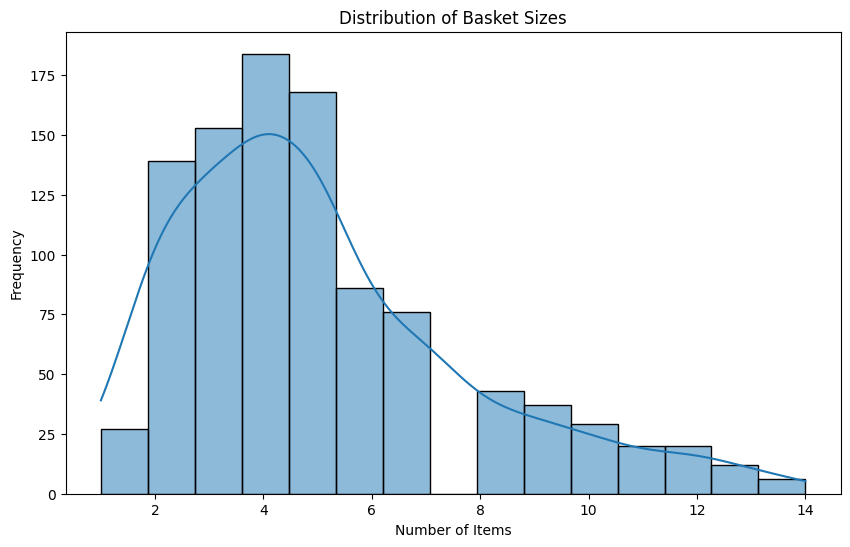

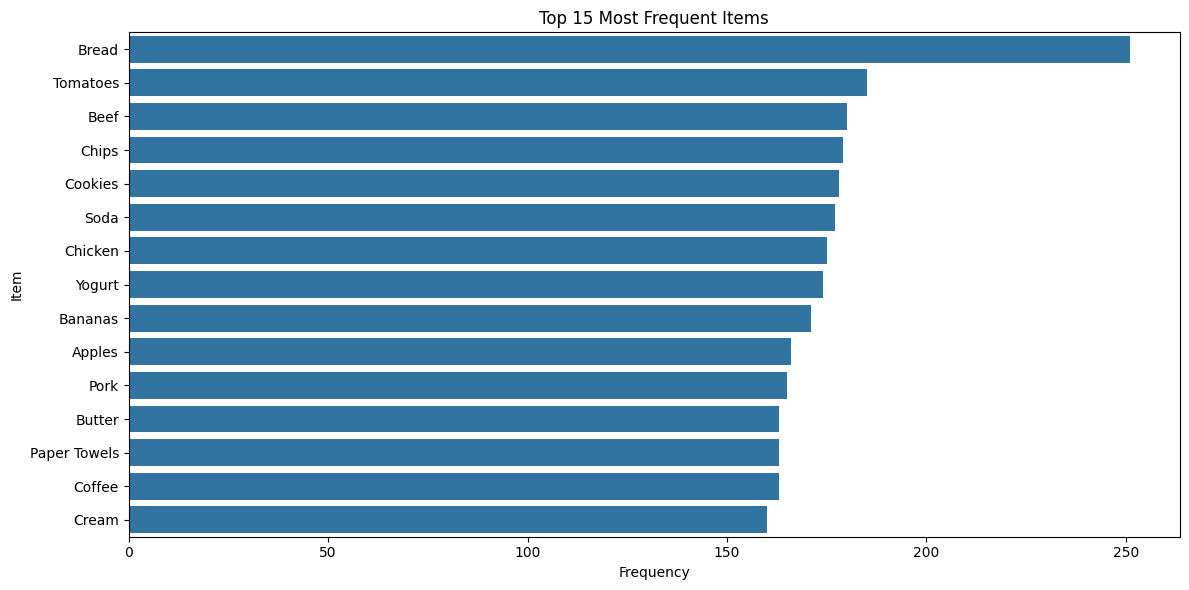

,Apples,Bagels,Bananas,Beef,Bread,Butter,Cake,Candy,Cheese,Chicken,Chips,Chocolate,Cleaning Supplies,Coffee,Cookies,Cream,Fish,Juice,Laundry Detergent,Lettuce,Milk,Muffins,Nuts,Oranges,Paper Towels,Pork,Pretzels,Sausages,Soda,Tea,Tissues,Tomatoes,Trash Bags,Water,Yogurt
0,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,True,True,False,False,False,False,True,False,True,True,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,True,False,False,False
3,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [12]:
# Explore the dataset
print(f"Total transactions: {len(transaction_data)}")

# Distribution of basket sizes
transaction_data['BasketSize'] = transaction_data['Items'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(transaction_data['BasketSize'], bins=15, kde=True)
plt.title('Distribution of Basket Sizes')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.show()

# Calculate item frequency
item_counts = {}
for basket in transactions:
    for item in basket:
        if item in item_counts:
            item_counts[item] += 1
        else:
            item_counts[item] = 1

# Convert to DataFrame and sort
item_freq = pd.DataFrame(list(item_counts.items()), columns=['Item', 'Frequency'])
item_freq['Percentage'] = 100 * item_freq['Frequency'] / len(transaction_data)
item_freq = item_freq.sort_values('Frequency', ascending=False).reset_index(drop=True)

# Display top 15 most frequent items
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Item', data=item_freq.head(15))
plt.title('Top 15 Most Frequent Items')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

# Convert to one-hot encoded format required for Apriori algorithm
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Display the first few rows of the one-hot encoded data
df.head()

## Apriori Algorithm

In [13]:
# Apply the Apriori algorithm to find frequent itemsets
# min_support determines how frequently an itemset should appear to be considered 'frequent'
min_support = 0.01  # Items appearing in at least 1% of transactions
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

# Sort by support
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

# Display frequent itemsets
print(f"Found {len(frequent_itemsets)} frequent itemsets with minimum support of {min_support}")
frequent_itemsets.head(10)

# Generate association rules
# min_threshold sets the minimum value for metrics like confidence
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort rules by lift (higher lift = stronger association)
rules = rules.sort_values('lift', ascending=False)

# Display the top association rules
print(f"Generated {len(rules)} association rules")
rules.head(10)

Found 863 frequent itemsets with minimum support of 0.01
Generated 2106 association rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1189,(Bagels),"(Chicken, Coffee)",0.113,0.023,0.012,0.106195,4.617160,1.0,0.009401,1.093079,0.883221,0.096774,0.085153,0.313967
1188,"(Chicken, Coffee)",(Bagels),0.023,0.113,0.012,0.521739,4.617160,1.0,0.009401,1.854636,0.801859,0.096774,0.460811,0.313967
1644,"(Yogurt, Laundry Detergent)",(Trash Bags),0.020,0.114,0.010,0.500000,4.385965,1.0,0.007720,1.772000,0.787755,0.080645,0.435666,0.293860
1645,(Trash Bags),"(Yogurt, Laundry Detergent)",0.114,0.020,0.010,0.087719,4.385965,1.0,0.007720,1.074231,0.871332,0.080645,0.069101,0.293860
1708,"(Lettuce, Coffee)",(Pretzels),0.022,0.108,0.010,0.454545,4.208754,1.0,0.007624,1.635333,0.779550,0.083333,0.388504,0.273569
1709,(Pretzels),"(Lettuce, Coffee)",0.108,0.022,0.010,0.092593,4.208754,1.0,0.007624,1.077796,0.854709,0.083333,0.072181,0.273569
2104,(Water),"(Trash Bags, Tissues)",0.121,0.020,0.010,0.082645,4.132231,1.0,0.007580,1.068288,0.862344,0.076336,0.063923,0.291322
2101,"(Trash Bags, Tissues)",(Water),0.020,0.121,0.010,0.500000,4.132231,1.0,0.007580,1.758000,0.773469,0.076336,0.431172,0.291322
1300,"(Tea, Yogurt)",(Trash Bags),0.025,0.114,0.011,0.440000,3.859649,1.0,0.008150,1.582143,0.759907,0.085938,0.367946,0.268246
1301,(Trash Bags),"(Tea, Yogurt)",0.114,0.025,0.011,0.096491,3.859649,1.0,0.008150,1.079126,0.836241,0.085938,0.073324,0.268246


## Evaluation & Intrepretation


Interpretation of the top rule:
If a customer buys Bagels, there is a 10.62% probability
they will also buy Chicken, Coffee.
This association appears in 1.20% of all transactions.
The lift value of 4.62 indicates that these items are
4.62 times more likely to be purchased together than if they were independent.


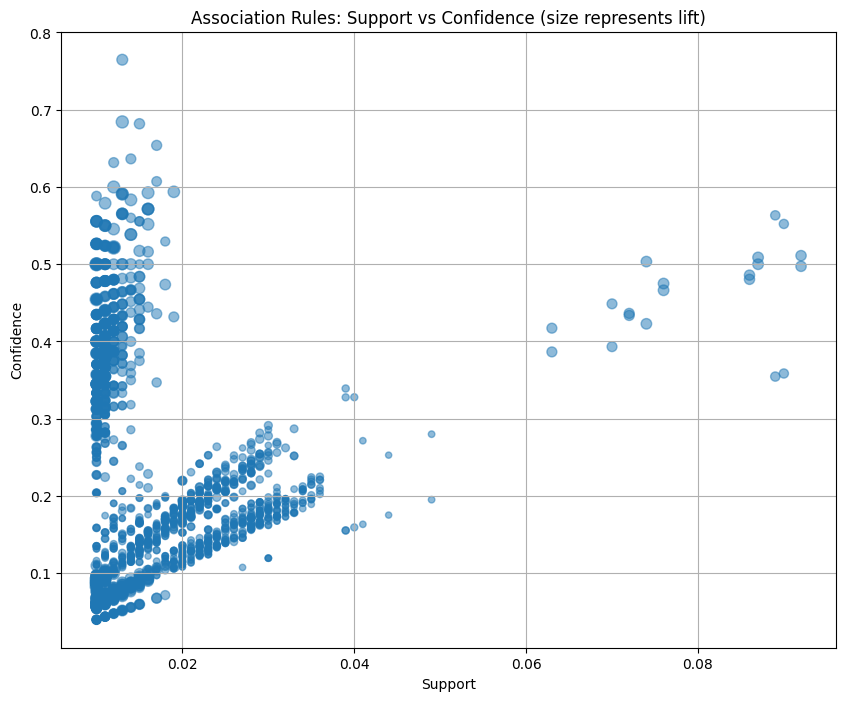

In [14]:
# Function to convert frozen sets to readable strings for display
def format_itemset(itemset):
    return ', '.join(list(itemset))

# Add formatted columns for better readability
rules['antecedents_str'] = rules['antecedents'].apply(format_itemset)
rules['consequents_str'] = rules['consequents'].apply(format_itemset)

# Display the top rules with formatted itemsets
top_rules = rules.head(10)[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']]
top_rules.columns = ['If customer buys', 'They also buy', 'Support', 'Confidence', 'Lift']
top_rules

# Interpret key metrics for the top rule
print("\nInterpretation of the top rule:")
top_rule = rules.iloc[0]
print(f"If a customer buys {format_itemset(top_rule['antecedents'])}, there is a {top_rule['confidence']:.2%} probability")
print(f"they will also buy {format_itemset(top_rule['consequents'])}.")
print(f"This association appears in {top_rule['support']:.2%} of all transactions.")
print(f"The lift value of {top_rule['lift']:.2f} indicates that these items are")
print(f"{top_rule['lift']:.2f} times more likely to be purchased together than if they were independent.")

# Scatter plot of rules by confidence and support, with lift as size
plt.figure(figsize=(10, 8))
plt.scatter(rules['support'], rules['confidence'], s=rules['lift']*20, alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (size represents lift)')
plt.grid(True)
plt.show()

## Visualization

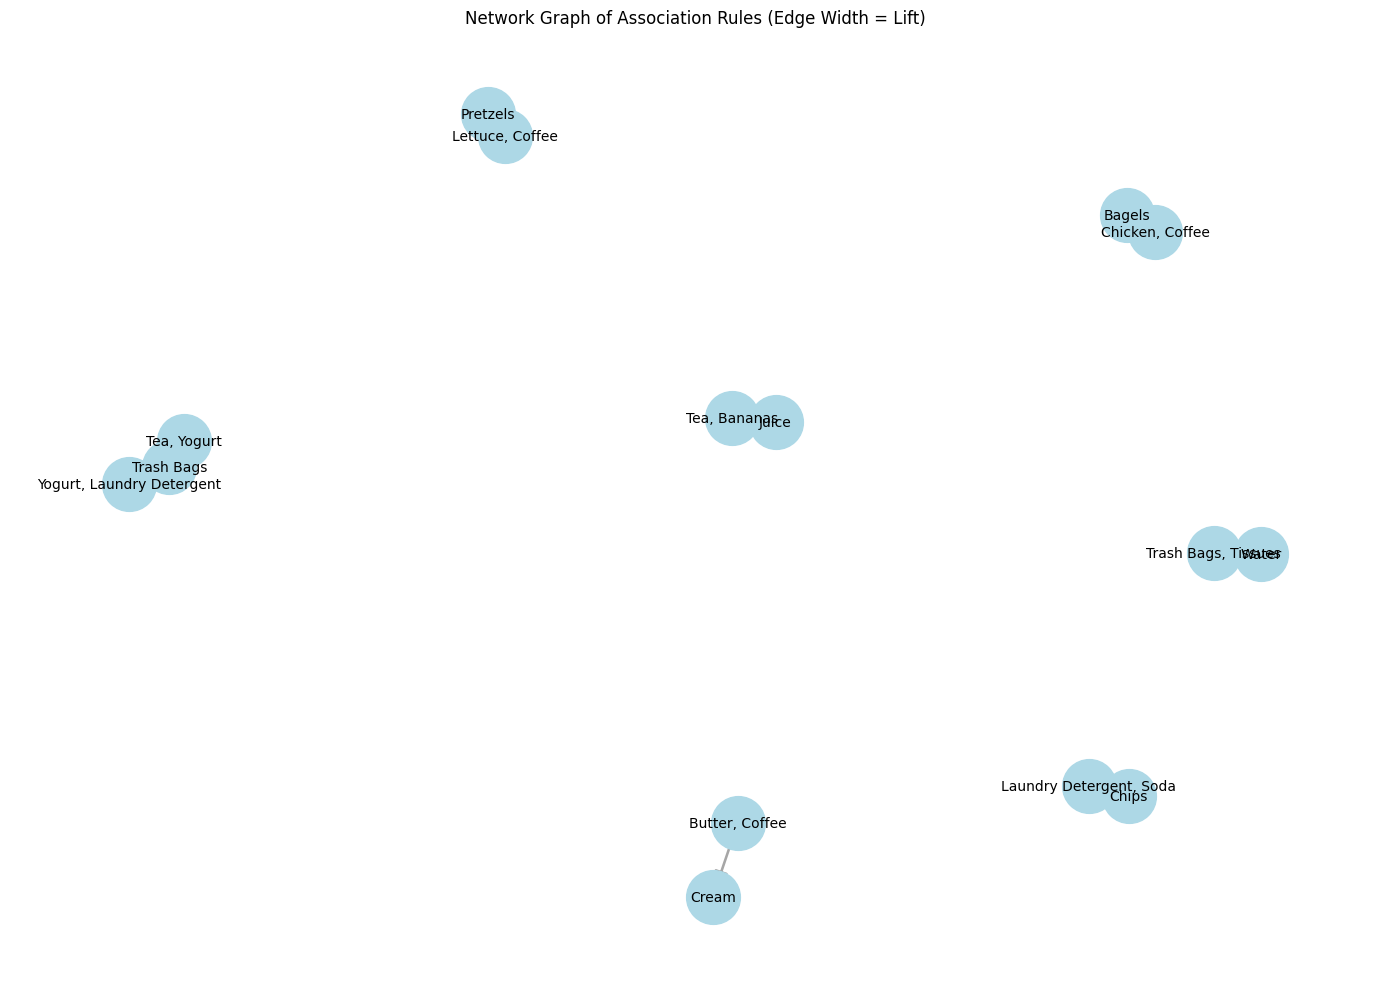

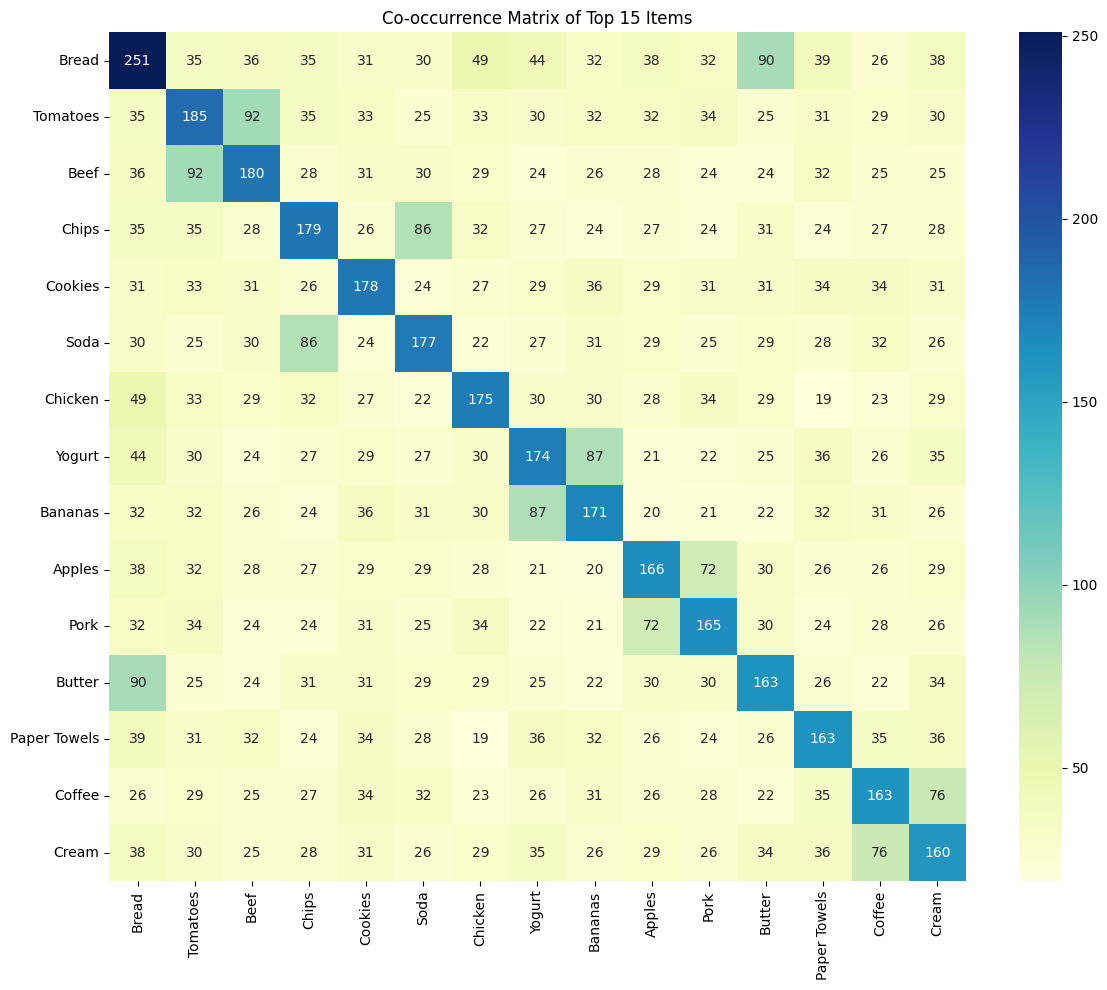

In [15]:
# Filter rules for visualization (top rules by lift)
top_rules_vis = rules.head(15)

# Network graph of association rules
G = nx.DiGraph()

# Add nodes and edges
for i, row in top_rules_vis.iterrows():
    antecedent = format_itemset(row['antecedents'])
    consequent = format_itemset(row['consequents'])
    
    # Add nodes
    if antecedent not in G.nodes:
        G.add_node(antecedent)
    if consequent not in G.nodes:
        G.add_node(consequent)
    
    # Add edge with lift as weight
    G.add_edge(antecedent, consequent, weight=row['lift'], 
               support=row['support'], confidence=row['confidence'])

# Plot the network
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')

# Draw edges with width based on lift
edges = G.edges(data=True)
edge_widths = [d['weight']/2 for u, v, d in edges]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, 
                       edge_color='grey', arrows=True, arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.title('Network Graph of Association Rules (Edge Width = Lift)')
plt.tight_layout()
plt.show()

# Heatmap of item co-occurrence
# Convert transactions to co-occurrence matrix
items = list(te.columns_)
n_items = len(items)
cooccur_matrix = np.zeros((n_items, n_items))

for transaction in transactions:
    for i, item1 in enumerate(items):
        if item1 in transaction:
            for j, item2 in enumerate(items):
                if item2 in transaction:
                    cooccur_matrix[i, j] += 1

# Create co-occurrence DataFrame (limited to top items for clarity)
top_items_indices = [list(items).index(item) for item in item_freq.head(15)['Item']]
top_items = [items[i] for i in top_items_indices]
cooccur_df = pd.DataFrame(cooccur_matrix[np.ix_(top_items_indices, top_items_indices)], 
                         index=top_items, columns=top_items)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooccur_df, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Co-occurrence Matrix of Top 15 Items')
plt.tight_layout()
plt.show()

## Business Insights

In [16]:
# Generate business insights from the analysis
insights = """
## Key Business Insights from Market Basket Analysis

1. **Product Placement Opportunities**
   - Items frequently purchased together should be placed near each other
   - For example: {example1}

2. **Bundling and Promotion Strategies**
   - Create product bundles based on high-lift associations
   - Special discounts for complementary products
   - For example: {example2}

3. **Cross-Selling Recommendations**
   - Use top association rules to suggest products
   - For example: "Customers who bought {example3[0]} also bought {example3[1]}"

4. **Inventory Management**
   - Stock complementary products together
   - Ensure high-association items don't run out simultaneously

5. **Store Layout Optimization**
   - Create 'customer journey' paths based on frequent itemsets
   - Strategic product placement for high-margin items
""".format(
    example1=format_itemset(rules.iloc[0]['antecedents']) + " and " + format_itemset(rules.iloc[0]['consequents']),
    example2=format_itemset(rules.iloc[1]['antecedents']) + " with " + format_itemset(rules.iloc[1]['consequents']),
    example3=[format_itemset(rules.iloc[2]['antecedents']), format_itemset(rules.iloc[2]['consequents'])]
)

print(insights)

# Calculate potential revenue impact
# Assuming average prices for product categories
avg_prices = {
    'Dairy': 3.50,
    'Bakery': 4.00,
    'Produce': 2.50,
    'Meat': 8.00,
    'Beverages': 3.00,
    'Snacks': 3.50,
    'Household': 5.00
}

def get_category(item):
    """Get the category of an item"""
    for category, items in categories.items():
        if item in items:
            return category
    return None

# Function to estimate price of an item
def estimate_price(item):
    category = get_category(item)
    if category:
        return avg_prices[category]
    return 3.50  # default price

# Calculate potential revenue impact from top associations
print("\nPotential Revenue Impact from Promotions:")
for i, row in rules.head(5).iterrows():
    antecedent_items = list(row['antecedents'])
    consequent_items = list(row['consequents'])
    
    # Calculate total basket value
    antecedent_value = sum(estimate_price(item) for item in antecedent_items)
    consequent_value = sum(estimate_price(item) for item in consequent_items)
    
    # Estimate impact of cross-selling
    num_transactions_with_antecedent = row['support'] / row['confidence'] * len(transaction_data)
    potential_additional_sales = num_transactions_with_antecedent * (1 - row['confidence']) * consequent_value
    
    print(f"\nRule {i+1}: {format_itemset(row['antecedents'])} → {format_itemset(row['consequents'])}")
    print(f"  - Average value of antecedent items: ${antecedent_value:.2f}")
    print(f"  - Average value of consequent items: ${consequent_value:.2f}")
    print(f"  - Estimated additional revenue from cross-selling: ${potential_additional_sales:.2f}")


## Key Business Insights from Market Basket Analysis

1. **Product Placement Opportunities**
   - Items frequently purchased together should be placed near each other
   - For example: Bagels and Chicken, Coffee

2. **Bundling and Promotion Strategies**
   - Create product bundles based on high-lift associations
   - Special discounts for complementary products
   - For example: Chicken, Coffee with Bagels

3. **Cross-Selling Recommendations**
   - Use top association rules to suggest products
   - For example: "Customers who bought Yogurt, Laundry Detergent also bought Trash Bags"

4. **Inventory Management**
   - Stock complementary products together
   - Ensure high-association items don't run out simultaneously

5. **Store Layout Optimization**
   - Create 'customer journey' paths based on frequent itemsets
   - Strategic product placement for high-margin items


Potential Revenue Impact from Promotions:

Rule 1190: Bagels → Chicken, Coffee
  - Average value of antecedent items: $

## Conclusions

In [17]:
# Summarize findings and suggest next steps
conclusion = """
## Conclusion and Next Steps

### Summary of Findings
- Identified {num_frequent} frequent itemsets and {num_rules} association rules
- Discovered strong associations between complementary products
- Found unexpected product relationships that can drive cross-selling strategies

### Limitations of the Analysis
- Sample data may not reflect actual purchasing patterns
- Seasonal variations not accounted for
- Customer segmentation not considered

### Next Steps
1. **Implement A/B Testing**
   - Test product placement recommendations
   - Evaluate promotion effectiveness

2. **Customer Segmentation**
   - Perform market basket analysis per customer segment
   - Identify segment-specific purchasing patterns

3. **Temporal Analysis**
   - Analyze how associations change over time
   - Identify seasonal patterns

4. **Recommendation System Integration**
   - Use association rules to power personalized recommendations
   - Implement in e-commerce platform or loyalty program
"""

print(conclusion.format(
    num_frequent=len(frequent_itemsets),
    num_rules=len(rules)
))


## Conclusion and Next Steps

### Summary of Findings
- Identified 863 frequent itemsets and 2106 association rules
- Discovered strong associations between complementary products
- Found unexpected product relationships that can drive cross-selling strategies

### Limitations of the Analysis
- Sample data may not reflect actual purchasing patterns
- Seasonal variations not accounted for
- Customer segmentation not considered

### Next Steps
1. **Implement A/B Testing**
   - Test product placement recommendations
   - Evaluate promotion effectiveness

2. **Customer Segmentation**
   - Perform market basket analysis per customer segment
   - Identify segment-specific purchasing patterns

3. **Temporal Analysis**
   - Analyze how associations change over time
   - Identify seasonal patterns

4. **Recommendation System Integration**
   - Use association rules to power personalized recommendations
   - Implement in e-commerce platform or loyalty program

